In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import balance

In [2]:
tables = balance.read_NIOT('NIOTS/RUS_NIOT_nov16.xlsx')
table = tables[14]
key = jax.random.PRNGKey(1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# __I\O - таблицы__

Пусть экономика состоит из $n$ промышленных отраслей, производящие __вторичные ресурсы__ и потребляющая $m$ видов __первичных ресурсов__, так же пусть имеется $l$ __конечных потребителей__, потребляющие вторичные ресурсы. Тогда можно ввести __I/O__-таблицу $\hat{Z}$ размера $(n+m)\times(n+l)$, в ячейках которой записаны потоки товаров из одной отрасли в другую.

Одним из примеров баз данных можно привести $NIOT$, разделяющую экономику на $n=56$ отраслей и $l = 6$ конечных потребителя. Так же в этих таблицах можно выделить $m=3$ первичных ресурса. Так как статистика потребления первичных ресурсов конечными потребителями в некотором смысле плохая, будем считать, что конечные потребители не потребляют первичные рессурсы.

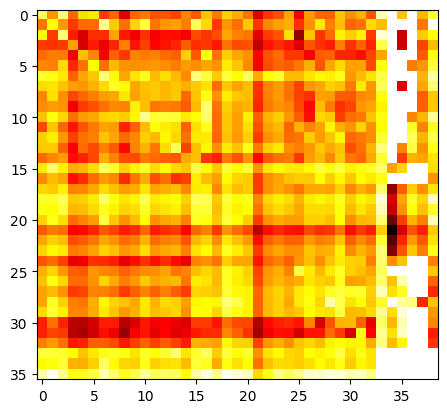

In [3]:
plt.imshow(jnp.log(table), cmap='hot', interpolation='nearest')
plt.show()

# __Производственные Функции__

Рассмотрим модель экономики, называемой __Межотраслевым Балансом__. Неформально ее можно описать как набор производственных функций и потребителей, которые закупаясь по некоторым рыночным ценам и максимизируя полезность\доход воспроизводят(приближенно) __I/O__-таблицы.   Допустимых функций бесконечно много - вопрос в том как такие найти. Хорошим классом является CES. Для любой корректной $\hat{Z}$ и люого $\rho\in\mathbb{R}^{n}_{++}$ существуют веса $W$, что в равновесных ценах пропорции воспроизведутся. Стартанем отсюда.

In [4]:
n, m, l = 33, 3, 6
Z_hat = table[:,:n]
rho = jax.random.uniform(key, (n,), minval=1, maxval = 5)
W = balance.get_W(Z_hat, rho)

Имея на руках производственные функции можно найти равновесные цены, полагая $s$ зафиксированным(и единичным).

In [5]:
cost_f = jax.jit(lambda p: balance.CES(p, W, rho))
s = jnp.array(jnp.ones(m))
p = balance.get_prices(cost_f, n, s)

Имея равновесные цены $p$ можно рассчитать и пропорции потребления. Важно заметить, что это именно пропорции, а не точное воспроизведение.
В дальнейшем мы будем так же и масштабировать, чтоб получить функцию ошибки, и ее дифференциировать. Как видно они похожи, но не 1 в 1
(а разве не должны быть 1 в 1?)

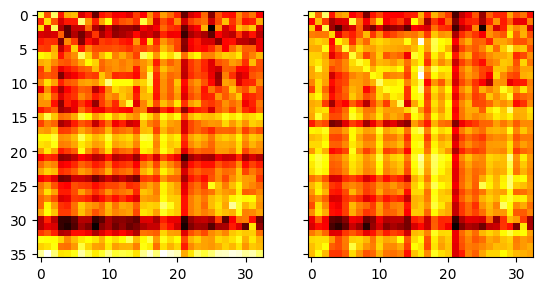

In [6]:
Z = balance.JCES(p, W, rho)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(Z), cmap='hot', interpolation='nearest')

Подгоним масштабирующие коэффициенты так, чтоб из пропорций потребления получились наиболее приближенными к данным. При этом очень важно учесть, что так же должен существовать и вектор конечного потребления, чтоб воспроизводилась корректная __I/O__-таблица. Поиск такий масштабирующих коэффициентов можно записать как задачу линейного программирования. 

In [7]:
J1, x, u = balance.primal_J(Z, Z_hat)
J1

3270418.221102603

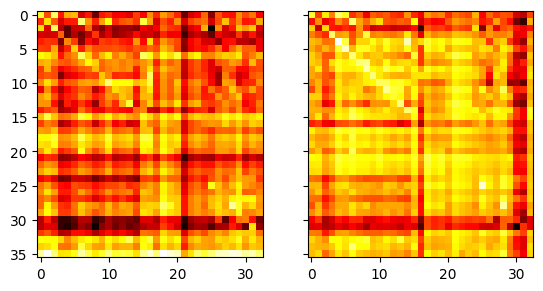

In [8]:
Z = balance.JCES(p, W, rho)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(x * Z), cmap='hot', interpolation='nearest')

In [9]:
jnp.sum(Z_hat - x * Z)/jnp.sum(Z_hat)

Array(0.9105051, dtype=float32)

Да чет ну совсем не похоже, оно объясняет только 10% от потребления.
Протестируем как вообще работает primal_J

Но по-хорошему оно должно в точности воспроизводить потребление $\hat{Z}$, а не приближенно. Более чем уверен, что ошибка в balance.get_W, но вроде все правильно. Поговорю на этот счет с научем. Во всем остальном уверен. Нужно посчитать $\nabla_{Z} J$ и попытаться _выучить_ пропорции $\hat{Z}$. Тогда можно будет раскручитвать подход дальше.

In [10]:
J2, nu, lam = balance.dual_J(Z, Z_hat)
J1, J2

(3270418.221102603, 3270418.2166799353)

In [11]:
(J1 - J2)/J1

1.3523247295297393e-09

In [12]:
balance.grad_J(Z, Z_hat)

error= 0.96727043


Array([[ -7600.7544  ,  -3241.1526  ,  -1020.86694 , ...,   -524.97577 ,
          -129.8917  , -37358.875   ],
       [ -7420.1895  ,  -3165.942   ,   -989.0412  , ...,   -510.75406 ,
          -126.389595, -36805.703   ],
       [ -9409.574   ,  -3994.58    ,  -1339.6835  , ...,   -667.44226 ,
          -164.97412 , -42900.31    ],
       ...,
       [ -9409.574   ,  -3994.58    ,  -1339.6835  , ...,   -667.44226 ,
          -164.97412 , -42900.31    ],
       [ -9409.574   ,  -3994.58    ,  -1339.6835  , ...,   -667.44226 ,
          -164.97412 , -42900.31    ],
       [ -9409.574   ,  -3994.58    ,  -1339.6835  , ...,   -667.44226 ,
          -164.97412 , -42900.31    ]], dtype=float32)

Попытаемся через градиентный спуск выучить пропорции. Зафиксируем случайный стартовый $Z$ и градиентным спуском минимизировать $J$. По-хорошему нужно провести анализ, чтоб определить параметры, может быть взять что-то универсальное. Но пока так.

In [13]:
n, m, l = 33, 3, 6
Z_hat = table[:,:n]
Z =  jax.random.uniform(key,(n+m, n))
for k in range(20):
    print(k)
    grad = balance.grad_J(Z, Z_hat)
    Z -= 1000 * grad
    Z = jnp.maximum(Z, jnp.zeros((n+m,n)))

0
error= 0.9610418
1
error= 0.80884546
2
error= 0.80884206
3
error= 0.80883867
4
error= 0.80883527
5
error= 0.8088318
6
error= 0.8088284
7
error= 0.808825
8
error= 0.8088216
9
error= 0.8088182
10
error= 0.8088148
11
error= 0.8088114
12
error= 0.80880797
13
error= 0.8088046
14
error= 0.8088012
15
error= 0.8087978
16
error= 0.8087944
17
error= 0.8087909
18
error= 0.8087875
19
error= 0.8087841


0.8087807


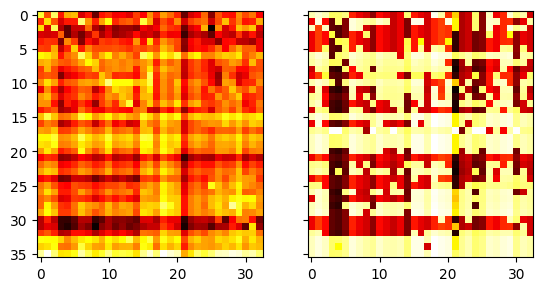

In [14]:
J, x, u = balance.primal_J(Z,Z_hat)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
print(J/jnp.sum(Z_hat))
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(x * Z), cmap='hot', interpolation='nearest')

In [17]:
balance.grad_J(Z, Z_hat)

error= 0.8087807


Array([[-0.00250254,  0.00630954, -0.00318775, ...,  0.00077263,
         0.00234828, -0.00200815],
       [-0.00250254,  0.00194896, -0.00318775, ..., -0.00077263,
        -0.00234828, -0.00200815],
       [-0.00250254, -0.00630954, -0.00318775, ..., -0.00077263,
        -0.00234828, -0.00200815],
       ...,
       [-0.00250254, -0.00630954, -0.00318775, ..., -0.00077263,
        -0.00234828, -0.00200815],
       [-0.00250254, -0.00630954, -0.00318775, ...,  0.00024578,
        -0.00234828, -0.00200815],
       [-0.00250254, -0.00630954, -0.00318775, ..., -0.00077263,
        -0.00234828, -0.00200815]], dtype=float32)

Кажись сама задача по подгону $Z$ невыпуклая ну совсем, быстро находится локальный минимум, сильно далекий от оптимума.
Осталось надеятся, что предсказанные пропорции сразу попадут в один бассейн с оптимумом.

__Проверим как оно ДООБУЧИТ предсказанные пропорции__

In [18]:
n, m, l = 33, 3, 6
Z_hat = table[:,:n]
rho = jax.random.uniform(key, (n,), minval=1, maxval = 5)
W = balance.get_W(Z_hat, rho)

In [19]:
cost_f = jax.jit(lambda p: balance.CES(p, W, rho))
s = jnp.array(jnp.ones(m))
p = balance.get_prices(cost_f, n, s)

In [27]:
Z = balance.JCES(p, W, rho)
for k in range(100):
    print(k)
    grad = balance.grad_J(Z, Z_hat)
    Z -= grad
    Z = jnp.maximum(Z, jnp.zeros((n+m,n)))

0
error= 0.96727043
1
error= 0.9257886
2
error= 0.9216819
3
error= 0.9177013
4
error= 0.91352886
5
error= 0.90978
6
error= 0.90548205
7
error= 0.90198106
8
error= 0.8989958
9
error= 0.8971608
10
error= 0.8938456
11
error= 0.8909925
12
error= 0.8866304
13
error= 0.88439053
14
error= 0.8816439
15
error= 0.8790627
16
error= 0.8787971
17
error= 0.8778112
18
error= 0.87530035
19
error= 0.87584895
20
error= 0.87391263
21
error= 0.8733534
22
error= 0.8719465
23
error= 0.87172395
24
error= 0.86989754
25
error= 0.87043035
26
error= 0.86773425
27
error= 0.86831903
28
error= 0.8657231
29
error= 0.8667253
30
error= 0.864786
31
error= 0.86410326
32
error= 0.8626779
33
error= 0.86295027
34
error= 0.86006904
35
error= 0.8623753
36
error= 0.85613865
37
error= 0.8645752
38
error= 0.8509693
39
error= 0.85495645
40
error= 0.85452193
41
error= 0.8511792
42
error= 0.85365945
43
error= 0.8459749
44
error= 0.8491509
45
error= 0.84697735
46
error= 0.8468421
47
error= 0.842809
48
error= 0.84548366
49
error= 0.

0.8218904


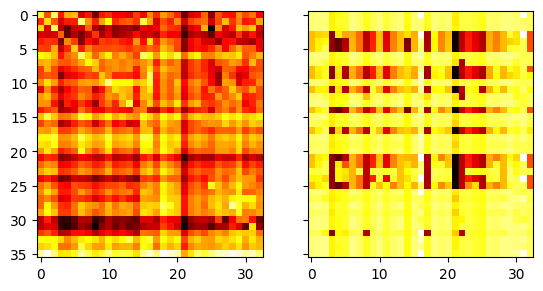

In [28]:
J, x, u = balance.primal_J(Z,Z_hat)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
print(J/jnp.sum(Z_hat))
ax1.imshow(jnp.log(Z_hat), cmap='hot', interpolation='nearest')
ax2.imshow(jnp.log(x * Z), cmap='hot', interpolation='nearest')

И близко нет, видимо придется делать штуку с воспроизведением по вектору потребления. Все эти игры с  "отковыриванием" вектора потребления были ошибкой.
Нужно откатить изменения для генерации $W$ и переписать ошибку $J$ чтоб оно приближало лучшим способом при условии воспроизведения вектора потребления. Видимо он должен тоже быть __на входе__ вместе с __ценами на первичные ресурсы__.